In [183]:
import pickle
from gensim.models import word2vec, Word2Vec
import multiprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
from imblearn.under_sampling import ClusterCentroids

%matplotlib inline

## Train Large Dataset

In [2]:
with open("./data/pcba_mol_sentences.pkl", "rb") as file:
    pcba_sentences = pickle.load(file)

In [46]:
dimensions = 100
window_size = 10
min_count = 3
negative = 15
iterations = 15

w2v = Word2Vec(pcba_sentences, size=dimensions, window=window_size, min_count=min_count, negative=negative, 
               iter=iterations, sg=1)

## Load ATC data

In [47]:
with open("./data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [48]:
atc = [sentence[1][0] for sentence in sentences]
sentences = [sentence[3] for sentence in sentences]

## Vectorisation

In [49]:
vectors = []

for sentence in sentences:
    vector = []
    for word in sentence:
        try:
            vector+=list(w2v.wv.word_vec(word))
        except:
            vector+=([0 for a in range(0, dimensions)])
    vectors.append(vector)
    
vectors = np.asarray(vectors)

In [50]:
sum_vectors = []

for vector in vectors:
    arr = np.asarray(vector)
    arr = arr.reshape((int(arr.shape[0]/dimensions), dimensions) )
    sum_vectors.append(arr.sum(axis=0))

sum_vectors = np.asarray(sum_vectors)

In [51]:
le = LabelEncoder()
le.fit(atc)

atc = le.transform(atc)

## T-SNE

In [52]:
ile = le.inverse_transform(np.asarray(range(0, 14)))

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(sum_vectors)

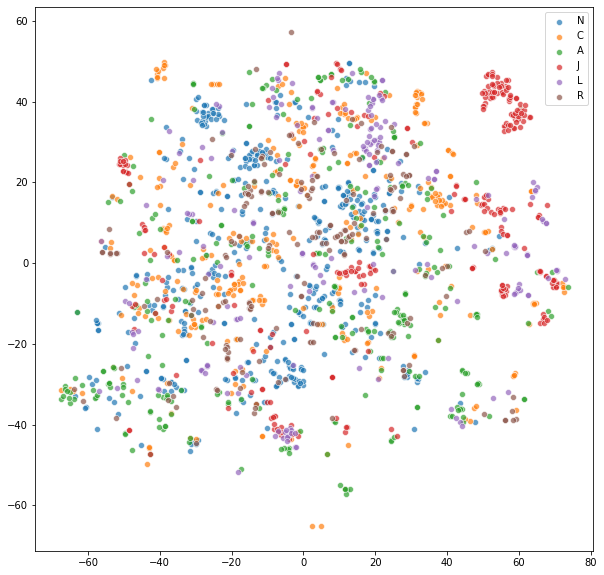

In [198]:
plt.figure(figsize=(10, 10))
top_atc_labels = [a for a,_ in Counter(atc).most_common(6)]
for i in top_atc_labels:
    sns.scatterplot(X_2d[atc == i, 0], X_2d[atc == i, 1], label=ile[i], palette=sns.color_palette("hls", 10), 
                    legend="full", alpha=0.7)

## Helper Functions

In [147]:
def accuracy(y_true, y_pred, atc_labels=atc_labels):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True,cbar=False, xticklabels=atc_labels, yticklabels=atc_labels)

In [184]:
def balance(X, y):    
    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X, y)
    return X_resampled, y_resampled

## Data Preparation

In [185]:
X = sum_vectors
y = atc

atc_counter = Counter(y)
top_atc = [a for a, _ in atc_counter.most_common(4)]

temp_x = []
temp_y = []

for i in range(y.shape[0]):
    if y[i] in top_atc:
        temp_x.append(X[i])
        temp_y.append(y[i])
        
X = np.asarray(temp_x)
y = np.asarray(temp_y)

X, y = balance(X, y)

atc_labels = le.inverse_transform(np.unique(y))

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=int(random.random()*100))

## KNN

In [187]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Overall Accuracy: 0.661849710982659
             precision    recall  f1-score   support

          0       0.65      0.59      0.62       101
          2       0.59      0.60      0.59        78
          6       0.78      0.86      0.82        71
          9       0.64      0.64      0.64        96

avg / total       0.66      0.66      0.66       346



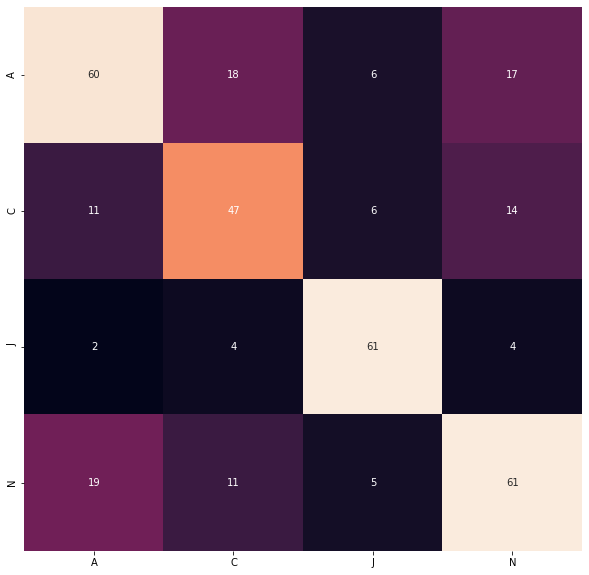

In [188]:
y_pred = neigh.predict(X_test)
accuracy(y_pred, y_test, atc_labels)

## Random Forest

In [189]:
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion='entropy')
# Fit on training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Overall Accuracy: 0.6589595375722543
             precision    recall  f1-score   support

          0       0.48      0.63      0.54        70
          2       0.60      0.56      0.58        85
          6       0.81      0.79      0.80        80
          9       0.76      0.66      0.71       111

avg / total       0.67      0.66      0.66       346



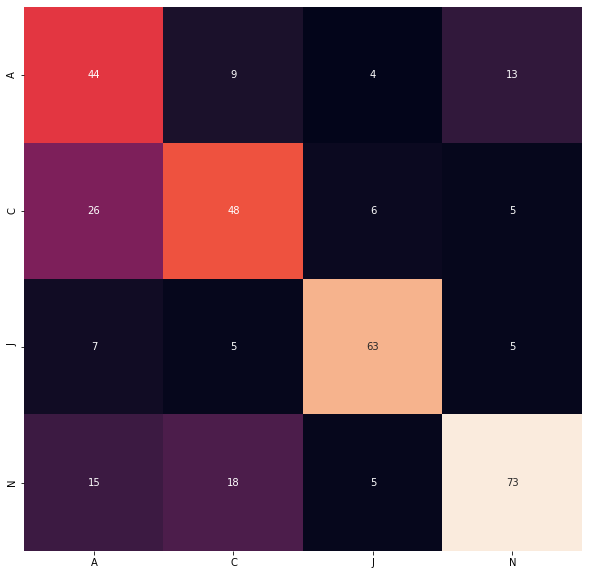

In [190]:
y_pred = rf_model.predict(X_test)
accuracy(y_pred, y_test, atc_labels)

## ANN

In [85]:
oeAtc = OneHotEncoder(sparse=False)
oeAtc.fit(y.reshape(-1, 1))
y_onehot = oeAtc.transform(y.reshape(-1, 1))

X_train, X_test, y_onehot_train, y_onehot_test = train_test_split(X, y_onehot, test_size=0.3, random_state=int(random.random()*100))

In [86]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Dense(50, input_dim=dimensions, activation='relu'))
        self.model.add(Dense(30, activation='relu'))
        self.model.add(Dense(20, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [87]:
network = Network(len(atc_labels))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 7,263
Trainable params: 7,263
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
network.train(X_train, y_onehot_train, X_test, y_onehot_test, epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 770 samples, validate on 331 samples
Epoch 1/10
770/770 [==============================] - 0s 478us/step - loss: 1.4965 - acc: 0.4584 - val_loss: 1.0398 - val_acc: 0.5770
Epoch 2/10
770/770 [==============================] - 0s 74us/step - loss: 0.9753 - acc: 0.5935 - val_loss: 0.9206 - val_acc: 0.5861
Epoch 3/10
770/770 [==============================] - 0s 72us/step - loss: 0.7972 - acc: 0.6610 - val_loss: 0.9033 - val_acc: 0.6284
Epoch 4/10
770/770 [==============================] - 0s 69us/step - loss: 0.7578 - acc: 0.6831 - val_loss: 0.8933 - val_acc: 0.6465
Epoch 5/10
770/770 [==============================] - 0s 77us/step - loss: 0.6941 - acc: 0.7299 - val_loss: 0.8122 - val_acc: 0.6647
Epoch 6/10
770/770 [==============================] - 0s 70us/step - loss: 0.6923 - acc: 0.7169 - val_loss: 0.7855 - val_acc: 0.6707
Epoch 7/10
770/770 [==============================] - 0s 60us/step - loss: 0.6386 - acc: 0.7403 - val_loss:

Overall Accuracy: 0.7190332326283988
             precision    recall  f1-score   support

          0       0.60      0.58      0.59       102
          1       0.84      0.74      0.79        90
          2       0.73      0.81      0.77       139

avg / total       0.72      0.72      0.72       331



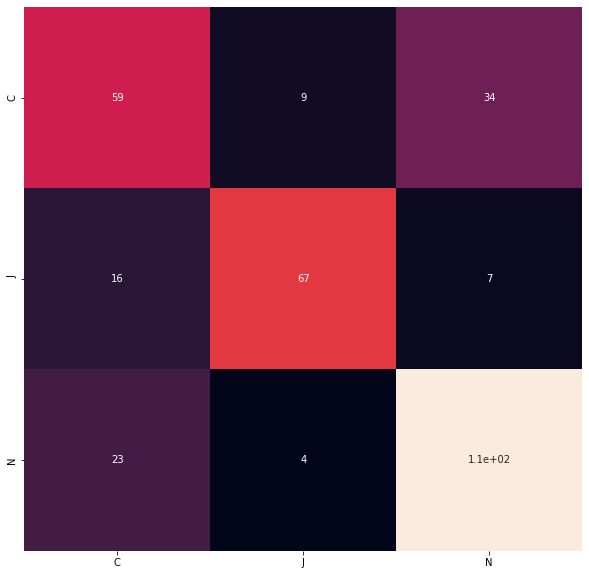

In [89]:
s = network.test(X_test, y_onehot_test)

## SVM

In [194]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Overall Accuracy: 0.3176470588235294


/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          2       0.02      0.29      0.04         7
          6       0.01      0.33      0.02         3
          9       0.96      0.32      0.48       415

avg / total       0.94      0.32      0.47       425



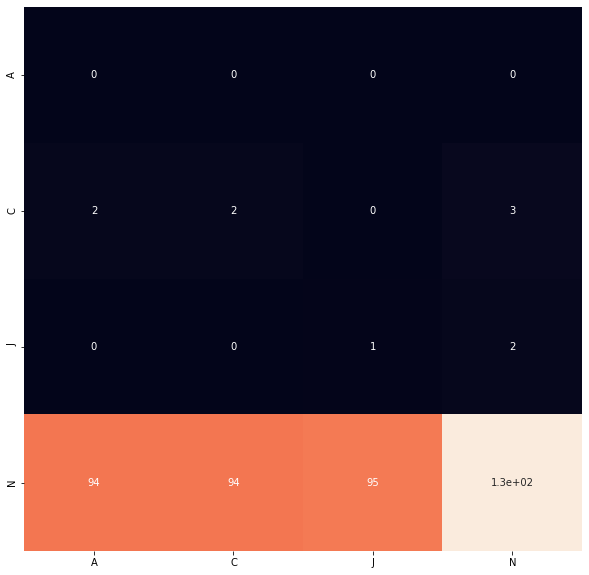

In [195]:
y_pred = clf.predict(X_test)
accuracy(y_pred, y_test, atc_labels)

## CNN RNN

In [86]:
with open("./data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [87]:
atc = [sentence[1][0] for sentence in sentences]
sentences = [sentence[3] for sentence in sentences]

In [258]:
vectors = []
max_identifiers = 300

for sentence in sentences[:1000]:
    vector = np.zeros(max_identifiers*dimensions)
    if len(sentence)>max_identifiers:
        continue
    for word in sentence:
        try:
            we = w2v.wv.word_vec(word)
            vector[:we.shape[0],:we.shape[1]] = we
            
        except:
            pass
    vectors.append(vector)
    
vectors = np.asarray(vectors).reshape(len(vectors), max_identifiers*dimensions)

In [259]:
vectors.shape

(1000, 90000)

In [260]:
le = LabelEncoder()
le.fit(atc)

atc = le.transform(atc)

In [261]:
Long_X = vectors
oeAtc = OneHotEncoder(sparse=False)
oeAtc.fit(y.reshape(-1, 1))
y_onehot = oeAtc.transform(y[:1000].reshape(-1, 1))

X_train, X_test, y_onehot_train, y_onehot_test = train_test_split(Long_X, y_onehot, test_size=0.3, 
                                                                  random_state=int(random.random()*100))

In [265]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Reshape((max_identifiers, dimensions), input_shape=(max_identifiers*dimensions, )))
        self.model.add(Conv1D(192, 5, activation='relu'))
        self.model.add(MaxPool1D(5))
#         self.model.add(BatchNormalization())        
#         self.model.add(Conv1D(192, 5, activation='relu'))
        self.model.add(Conv1D(140, 3, activation='relu'))
#         self.model.add(LSTM(70, dropout=0.7, recurrent_dropout=0.2, activation='selu', return_sequences=True,))
#         self.model.add(LSTM(70, dropout=0.4, recurrent_dropout=0.2, activation='relu'))
        self.model.add(Flatten())
#         self.model.add(Dense(100, activation='relu'))
        self.model.add(Dropout(rate=0.9))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [266]:
network = Network(len(atc_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 296, 192)          288192    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 59, 192)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 57, 140)           80780     
_________________________________________________________________
flatten_5 (Flatten)          (None, 7980)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7980)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 31924     
Total para

In [267]:
network.train(X_train, y_onehot_train, X_test, y_onehot_test, epochs=10)

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 8s 12ms/step - loss: 1.3855 - acc: 0.3057 - val_loss: 1.3831 - val_acc: 0.3967
Epoch 2/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3839 - acc: 0.3214 - val_loss: 1.3802 - val_acc: 0.3967
Epoch 3/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3827 - acc: 0.3214 - val_loss: 1.3775 - val_acc: 0.3967
Epoch 4/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3814 - acc: 0.3214 - val_loss: 1.3754 - val_acc: 0.3967
Epoch 5/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3804 - acc: 0.3214 - val_loss: 1.3737 - val_acc: 0.3967
Epoch 6/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3795 - acc: 0.3214 - val_loss: 1.3717 - val_acc: 0.3967
Epoch 7/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3787 - acc: 0.3214 - val_loss: 1.3699 - val_acc: 0.3967
Epoch 8/10
700/700 [=========

Overall Accuracy: 0.39666666666666667


/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        57
          1       0.00      0.00      0.00        56
          2       0.00      0.00      0.00        68
          3       0.40      1.00      0.57       119

avg / total       0.16      0.40      0.23       300



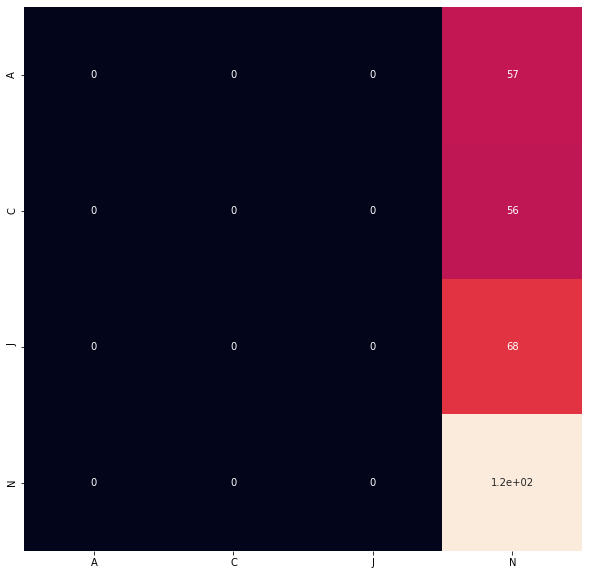

In [268]:
s = network.test(X_test, y_onehot_test)

In [195]:
Counter(atc).most_common(14)

[(9, 469),
 (2, 344),
 (0, 315),
 (6, 288),
 (7, 207),
 (11, 196),
 (3, 173),
 (4, 152),
 (8, 138),
 (13, 135),
 (12, 98),
 (10, 90),
 (1, 89),
 (5, 37)]

In [191]:
w2v.save("my_100.model")

In [ ]:
Counter